# How Exactly UMAP Works
### . . . and why exactly it is better than tSNE

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
In this article I will try to cover the math behind UMAP and give a detailed comparison of tSNE with UMAP in order to emphasize why UMAP is capable of capturing more of the global structure and is a faster algorithm. We will also make an attempt to program both tSNE and UMAP from scratch in Python.

### Table of Contents:
* [tSNE is Dead. Long Live UMAP!](#tSNE-is-Dead-.-Long-Live-UMAP!)
* [Brief Recap on How tSNE Works](#Brief-Recap-on-How-tSNE-Works)
* [Programming tSNE from Scratch](#Programming-tSNE-from-Scratch)
* [Key Differences Between tSNE and UMAP](#Key-Differences-Between-tSNE-and-UMAP)
* [Why tSNE Preserves Only Local Structure?](#Why-tSNE-Preserves-Only-Local-Structure?)
* [Why UMAP Can Preserve Global Structure](#Why-UMAP-Can-Preserve-Global-Structure)
* [Programming UMAP from Scratch](#Programming-UMAP-from-Scratch)
* [Why Exactly UMAP is Faster than tSNE](#Why-Exactly-UMAP-is-Faster-than-tSNE)
* [Open Questions to UMAP](#Open-Questions-to-UMAP)

### tSNE is Dead. Long Live UMAP!  <a class="anchor" id="tSNE-is-Dead-.-Long-Live-UMAP!"></a>

If you do not know what tSNE is, how it works and did not read the original revolutionary [van der Maaten & Hinton paper from 2008](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf), you probably do not need to know because **tSNE is basically dead by now**. Despite tSNE made a drammatic impact for single cell genomics and Data Science in general, it is widely recognized to have a few disadvantages which have to be fixed sooner or later.

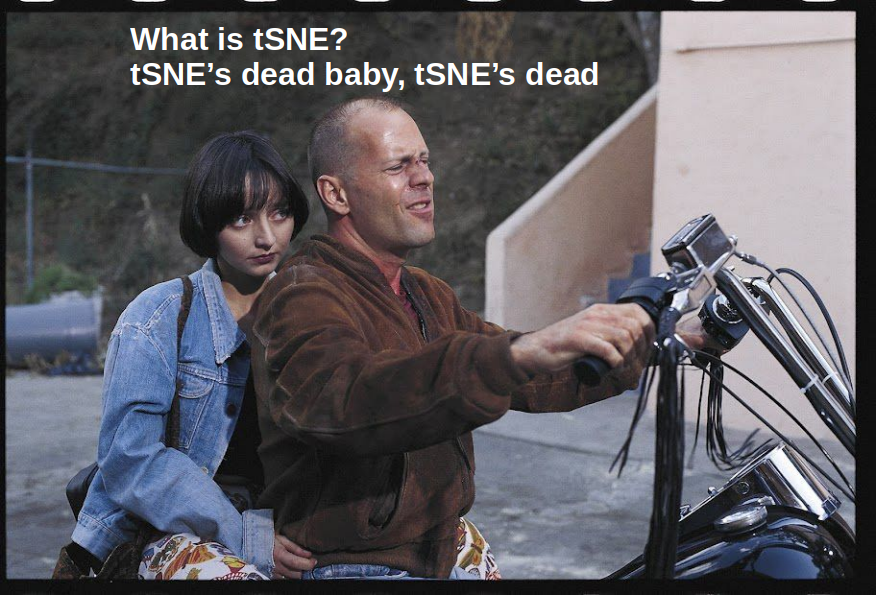

In [1]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/HowUMAPWorks/tSNE_is_Dead.png', width=2000)

What is it exactly that makes us uncomfortable using tSNE for single cell genomics? Here I summarize a few points with short comments:

* **tSNE does not scale** well for rapidly increasing sample sizes in scRNAseq. Attempts to speed it up with **FItSNE** result in **extreme memory consumption** making it impossible to do analysis outside of computer cluster, see my [banchmarking for 10X Genomics Mouse Brain 1.3M data set](https://towardsdatascience.com/deep-learning-for-single-cell-biology-935d45064438).


* **tSNE does not preserve global structure**, meaning that only within cluster distances are meningful while between cluster similarities are not guaranteed, therefore it is widely acknowleged that clustering on tSNE is not a very good idea.

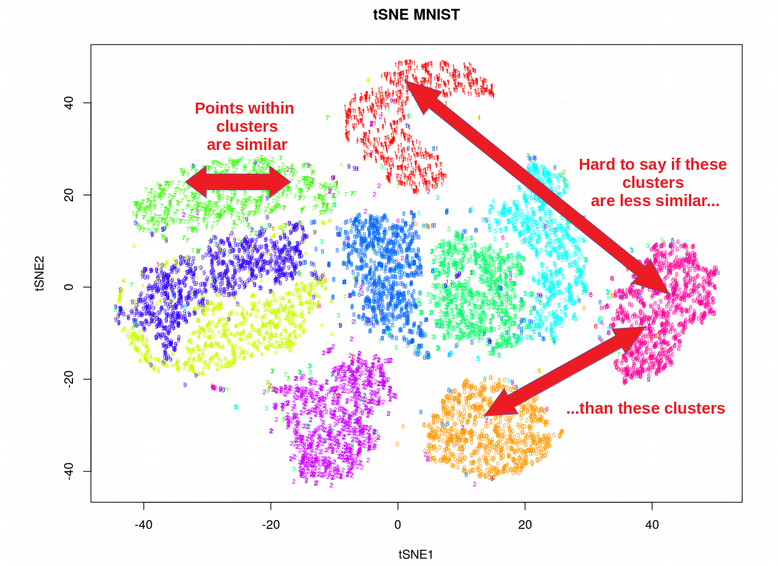

In [4]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/HowUMAPWorks/tSNE_MNIST_Clusters.png', width=2000)

* **tSNE can practically only embedd into 2 or 3 dimensions**, i.e. only for visualization purposes, so it is hard to use tSNE as a general dimensionality reduction technique in order to produce e.g. 10D or 50D low-dimensional representation. Please not that **this is still a problem for the more modern FItSNE algorithm**.


* **tSNE performs a non-parametric mapping** from high- to low-dimensional space, meaning that it does not leverage features (aka PCA loadings) that drive the observed clustering.


* **tSNE can not work with high-dimensional data directly**, i.e. PCA or Autoencoderr are often used for performing pre-dimensionality reduction before feeding it into tSNE


* **tSNE uses too much memory** for its computations which becomes especially obvious when using **large perplexity** hyperparameter since the k-nearest neigbor initial step (like in Barnes-Hut procedure) becomes less efficient and important for time reduction. **This problem is not solved by the more modern FItSNE algorithm either**.

### Brief Recap on How tSNE Works  <a class="anchor" id="Brief-Recap-on-How-tSNE-Works"></a>

tSNE is a relatively simple Machine Learning algorithm which can be summarized by the following four equations:

$$
p_{j|i} = \frac{\exp \left ( - || x_i - x_j || ^2 \big / 2 \sigma_i^2 \right ) }{\sum_{k \neq i} \exp \left ( - || x_i - x_k || ^2 \big / 2 \sigma_i^2 \right )}, \hspace{2em}
p_{ij} = \frac{p_{i|j} + p_{j|i}}{2N} \hspace{2em} (1)
$$

$$
\rm{Perplexity} = \displaystyle 2^{\displaystyle -\sum_j p_{j|i} \log_2 p_{j|i}} \hspace{2em} (2)
$$

$$
q_{ij} = \frac{ \left ( 1 + || y_i - y_j || ^2 \right ) ^ {-1} }{\sum_{k \neq l} \left ( 1 + || y_k - y_l || ^2 \right ) ^ {-1} } \hspace{2em} (3)
$$

$$
KL(P_i || Q_i) = \sum_i \sum_j p_{j|i} \log \frac {p_{j|i}} {q_{j|i}}, \hspace{2em} \frac{\partial KL}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij}) (y_i - y_j) \left ( 1 + || y_i - y_j || ^2 \right ) ^ {-1} \hspace{2em} (4)
$$


Eq. (1) defines the Gaussian probability of observing distances between any two points in the high-dimensional space, which satisfy the symmetry condition. Eq.(2) introduces the concept of Perplexity as a constraint that determines optimal $\sigma_i$ for each sample. Eq.(3) declares a **Student t-distribution** for the distances between the pairs of points in the low-dimensional embedding. The heavy tails of the Student t-distribution are to overcome the Crowding Problem when embedding into low dimensions. Eq. (4) provides the **Kullback-Leibler divergence** loss function for projection of high-dimensional probability onto the low-dimensional probability, and the analytical form of the gradient to be used in the **Gradient Descent** optimization.

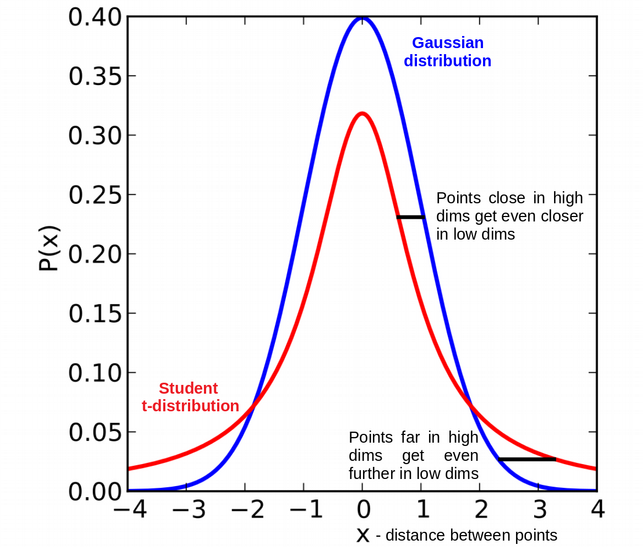

In [92]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/HowUMAPWorks/Gauss_vs_Student.png', width=2000)

Since tSNE is a really simple algorithm, let us try to program tSNE in Python from scratch.. As usually, we need to import necessary Python libraries, here we are going to use mostly numpy, so not so much to import:

### Programming tSNE from Scratch <a class="anchor" id="Programming-tSNE-from-Scratch"></a>

As a test data set, we will be using the [Cancer Associated Fibroblasts (CAFs)](https://www.nature.com/articles/s41467-018-07582-3) scRNAseq data. We start with importing Python libraries (mainly numpy and scikit-learn will be used), having a look at the data matrix and checking the dimensions of the data set. Please note, that the rows are cells and columns are genes here, the last column contains the coding of the clustering results, i.e. all cells belong to cluster # 1, 2, 3 or 4:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

path = '/home/nikolay/WABI/K_Pietras/Manifold_Learning/'
expr = pd.read_csv(path + 'bartoschek_filtered_expr_rpkm.txt', sep='\t')
print(expr.iloc[0:4,0:4])
X_train = expr.values[:,0:(expr.shape[1]-1)]
X_train = np.log(X_train + 1)
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = expr.values[:,expr.shape[1]-1]
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)

                1110020A21Rik  1110046J04Rik  1190002F15Rik  1500015A07Rik
SS2_15_0048_A3            0.0            0.0            0.0            0.0
SS2_15_0048_A6            0.0            0.0            0.0            0.0
SS2_15_0048_A5            0.0            0.0            0.0            0.0
SS2_15_0048_A4            0.0            0.0            0.0            0.0

This data set contains 716 samples

Dimensions of the  data set: 
(716, 557) (716,)


One important global variable to define from the very beginning is the martix of squared pairwise Euclidean distances for the initial high-dimensional scRNAseq data set, this matrix will be used a lot in the future code:

In [2]:
dist = np.square(euclidean_distances(X_train, X_train))
dist[0:4, 0:4]

array([[   0.        ,  914.95016311, 1477.46836099, 3036.91172176],
       [ 914.95016311,    0.        , 1307.39294642, 2960.41559961],
       [1477.46836099, 1307.39294642,    0.        , 2678.34442573],
       [3036.91172176, 2960.41559961, 2678.34442573,    0.        ]])

Next, using the matrix of squared pairwise Euclidean distances we will compute the matrix of probabilities in the high-dimensional space from Eq. (1). Knowing the matrix we can easily calculate the entory and perplexity as $2^{\rm{Entropy}}$. Please not the argument **sigma** of the function. This implies, the matrix of probabilities as a function of $\sigma$ will be used later for the binary search procedure that computes the optimal sigmas for the fixed perplexity. 

In [3]:
def prob_high_dim(sigma, dist_row):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    exp_distance = np.exp(-dist[dist_row] / (2*sigma**2))
    exp_distance[dist_row] = 0
    prob_not_symmetr = exp_distance / np.sum(exp_distance)
    #prob_symmetr = (prob_not_symmetr + prob_not_symmetr.T) / (2*n_samples)
    return prob_not_symmetr

def perplexity(prob):
    """
    Compute perplexity (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, -np.sum([p*np.log2(p) for p in prob if p!=0]))

A trick here is that for convenience in the future we compute a 1D array of probabilities for each i-th cell, i.e. for each i-th row (or column) of the squared pairwise Euclidean distance matrix (distance from i-th cell to all other cells in the data set). This is done because of $\sigma_i$ in the exponent in Eq. (1), i.e. we have to use the binary search in order to find $\sigma_i$ for each i-th cell in the data set. Next, for each i-th cell, given the 1D array of the high-dimenional probabilities, we can sum up the elements of the array and compute the Perplexity according to the definition in Eq. (2). So we have a function which produces the perplexity (scalar) value for each $\sigma_i$ for each i-th cell. Now we can fix the perplexity value (desired perplexity aka hyperparameter) and throw this function into the binary search procedure below in order to compute $\sigma_i$ for each i-th cell:

In [4]:
def sigma_binary_search(perp_of_sigma, fixed_perplexity):
    """
    Solve equation perp_of_sigma(sigma) = fixed_perplexity 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if perp_of_sigma(approx_sigma) < fixed_perplexity:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_perplexity - perp_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

Finally, we can define a lambda perplexity function of $\sigma_i$, fix the desired perplexity to e.g. 30 and run the binary search for each i-th cell. This will give us $\sigma_i$, substituting it back to Eq. (1) allows calculating the matrix of probabilities of pairwise Euclidean distances in the high-dimensional space. Technically, for each $\sigma_i$ we get a 1D array of probabilities; computing $\sigma_i$ for each cell we get a n-cells 1D arrays of proabilities which all together build a matrix of high-dimensional probabilities:

In [5]:
PERPLEXITY = 30
prob = np.zeros((n,n))
sigma_array = []
for dist_row in range(n):
    func = lambda sigma: perplexity(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, PERPLEXITY)
    prob[dist_row] = prob_high_dim(binary_search_result, dist_row)
    sigma_array.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array)))

Sigma binary search finished 100 of 716 cells
Sigma binary search finished 200 of 716 cells
Sigma binary search finished 300 of 716 cells
Sigma binary search finished 400 of 716 cells
Sigma binary search finished 500 of 716 cells
Sigma binary search finished 600 of 716 cells
Sigma binary search finished 700 of 716 cells

Mean sigma = 6.374859943070225


In [6]:
np.array(sigma_array)[0:20]

array([4.8456192 , 5.51700592, 5.00965118, 7.05623627, 6.4496994 ,
       8.22734833, 7.05432892, 5.62000275, 6.75868988, 5.3396225 ,
       7.68375397, 7.06005096, 5.95569611, 5.46550751, 4.69493866,
       5.47504425, 7.12680817, 6.15596771, 7.15732574, 5.60474396])

In [7]:
prob[0:4, 0:4]

array([[0.00000000e+00, 1.56103054e-02, 9.79824059e-08, 3.70810924e-22],
       [3.07204951e-03, 0.00000000e+00, 4.87134781e-06, 7.84507211e-18],
       [3.14890611e-05, 9.32673319e-04, 0.00000000e+00, 1.28124979e-15],
       [2.09788702e-09, 4.52270838e-09, 7.68375118e-08, 0.00000000e+00]])

Last thing we do, we apply the symmetry condition from Eq. (1). Now we are all done with Eqs. (1, 2). 

In [8]:
P = prob + np.transpose(prob)
#P = (prob + np.transpose(prob)) / (2*n)
#P = P / np.sum(P)

The major part of coding is over, to program the low-dimensional layout / embedding from Eq. (3) is really simple. Note that the matrix of low-dimensional probabilities, Eq. (3), accepts coordinates **Y** of the low-dimenional embeddings as a parameter. This implies, that the **Y** coordinates will be optimized later via the KL-divergence.

In [9]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = np.power(1 + np.square(euclidean_distances(Y, Y)), -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances, axis = 1, keepdims = True)

Actually, we are not going to use the definition of KL-divergence from Eq. (4) in the code, we only need the gradient of KL-divergence with respect to the coordinates **Y** of the low-dimensional embeddings. However, it is still good to calculate KL-divergence at each iteration of the Gradient Descent in order to see that it really decreases during optimization.

In [10]:
def KL(P, Y):
    """
    Compute KL-divergence from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return P * np.log(P + 0.01) - P * np.log(Q + 0.01)

Computing the gradient of KL-divergence from Eq. (4) is a bit tricky and I am using the method from the [blog of Liam Schoneveld](https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/):

In [11]:
def KL_gradient(P, Y):
    """
    Compute gradient of KL-divergence
    """
    Q = prob_low_dim(Y)
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + np.square(euclidean_distances(Y, Y)), -1)
    return 4*np.sum(np.expand_dims(P - Q, 2) * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

Now everything is ready for running Gradient Descent optimization. We will initialize the coordinates **Y** of the low-dimensional embedding using Normal distribution and update **Y** via the Gradient Descent rule. KL-divergence will be monitored along the way of optimization to control for its decreasing.

In [12]:
N_LOW_DIMS = 2
LEARNING_RATE = 0.6
MAX_ITER = 200

np.random.seed(12345)
y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))
KL_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * KL_gradient(P, y)
    
    plt.figure(figsize=(20,15))
    plt.scatter(y[:,0], y[:,1], c=y_train.astype(int), cmap = 'tab10', s = 50)
    plt.title("tSNE on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
    plt.xlabel("tSNE1", fontsize = 20); plt.ylabel("tSNE2", fontsize = 20)
    plt.savefig('tSNE_Plots/tSNE_iter_' + str(i) + '.png')
    plt.close()
    
    KL_array.append(np.sum(KL(P, y)))
    if i % 10 == 0:
        print("KL divergence = " + str(np.sum(KL(P, y))))

Running Gradient Descent: 

KL divergence = 2680.1458737583075
KL divergence = 2486.110581347542
KL divergence = 2364.579832543151
KL divergence = 2297.5892423792643
KL divergence = 2257.53836127498
KL divergence = 2227.8723522127966
KL divergence = 2204.4571714318536
KL divergence = 2193.652388856074
KL divergence = 2193.3620898893782
KL divergence = 2188.3719059537984
KL divergence = 2179.8640188523063
KL divergence = 2173.928616431854
KL divergence = 2167.5581502576747
KL divergence = 2166.7646345461867
KL divergence = 2146.268040423139
KL divergence = 2149.0989945050414
KL divergence = 2137.496939334292
KL divergence = 2140.807564691496
KL divergence = 2142.902614752898
KL divergence = 2134.508402134188


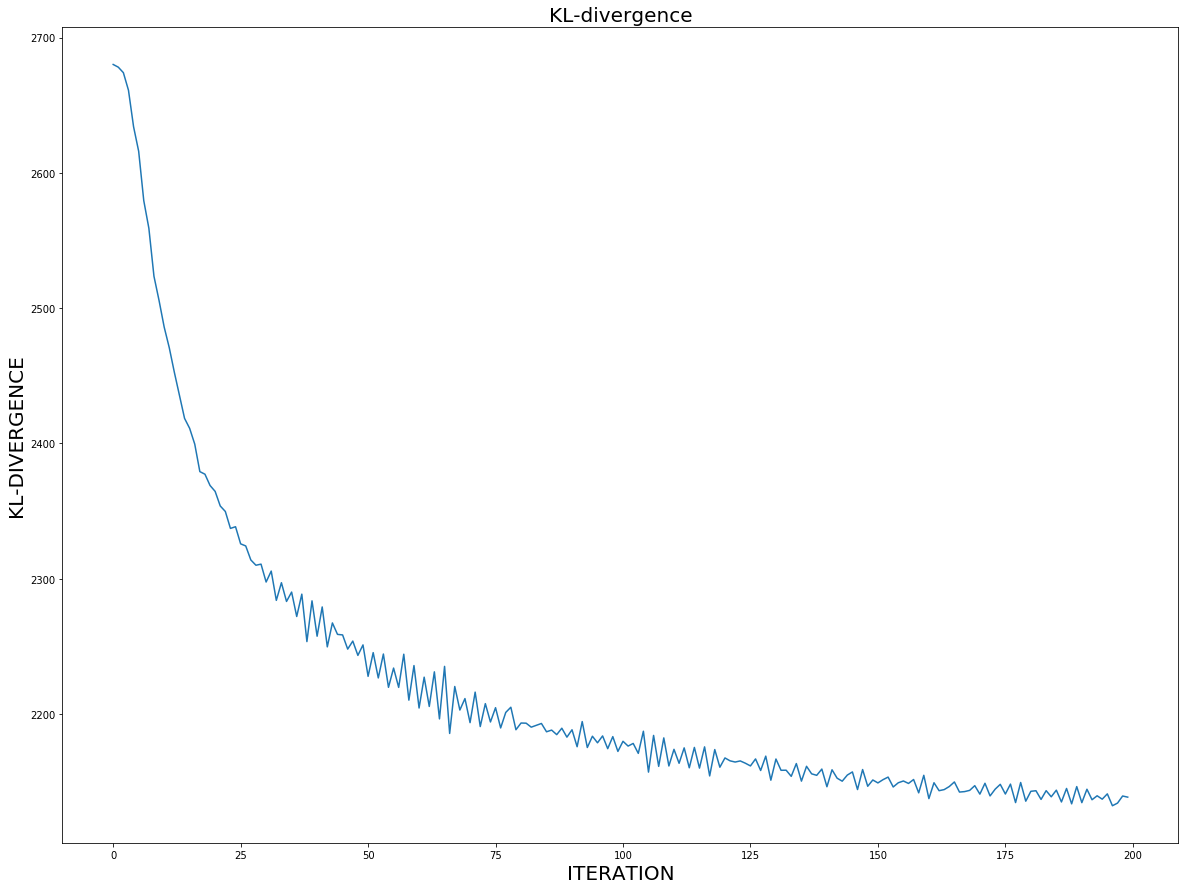

In [13]:
plt.figure(figsize=(20,15))
plt.plot(KL_array)
plt.title("KL-divergence", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("KL-DIVERGENCE", fontsize = 20)
plt.show()

Looks like the KL-divergence is decreasing, now it is time to display the final coordinates **Y** of the low-dimensional embeddings:

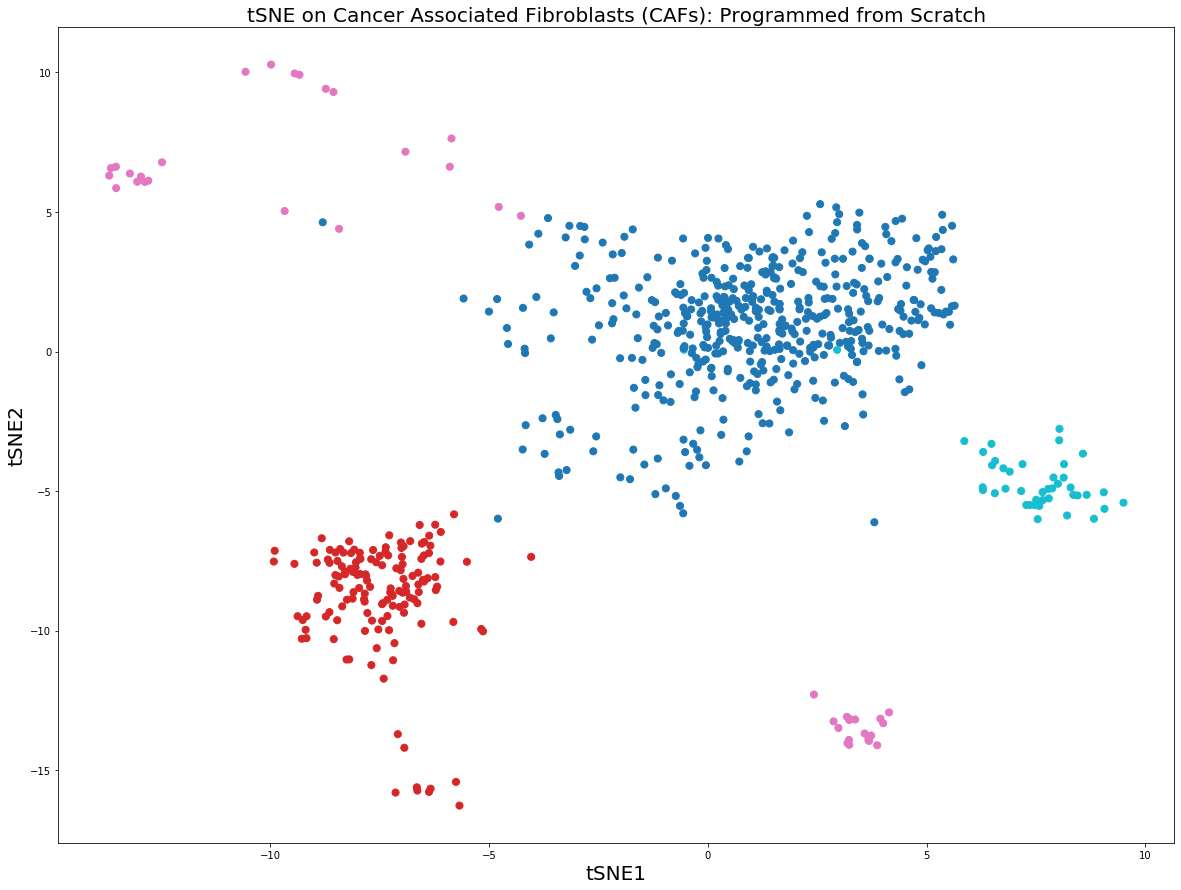

In [14]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c=y_train.astype(int), cmap = 'tab10', s = 50)
plt.title("tSNE on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
plt.xlabel("tSNE1", fontsize = 20); plt.ylabel("tSNE2", fontsize = 20)
plt.show()

The clusters are quite visible but somehow scattered. Let us visualize the animation of how the points group into the clusters:

In [15]:
#%%bash
#convert -delay 0 $(for i in $(seq 0 1 20; seq 21 10 199); do echo tSNE_iter_${i}.png; done) \
#-loop 0 tSNE_animated.gif

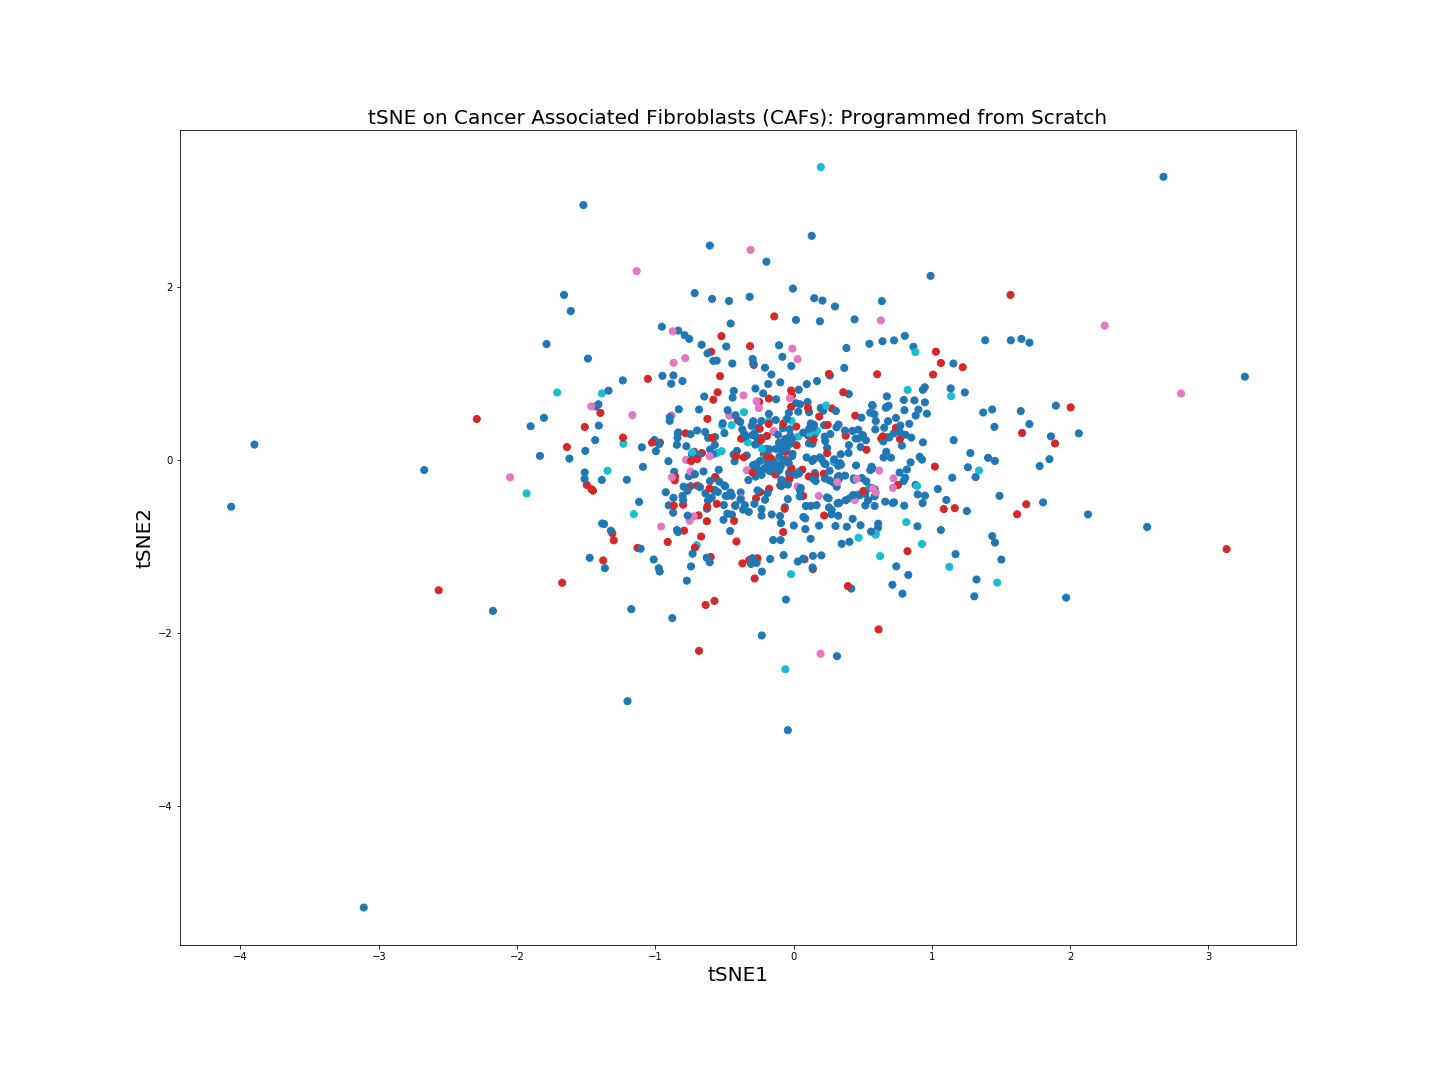

In [12]:
from IPython.display import Image
Image('/home/nikolay/Documents/Jupyter_Notebooks/tSNE_Plots/tSNE_animated.gif.png', width=2000)

For comparison, we will also run the scikit-learn version of tSNE in order to show how typically a tSNE for CAFs would look like. Please note that this is a default Burnes-Hut implementation meaning that the high-dimensional probabilities are computed for only nearest neighbours and the number of nearest neighbours is equal to 3\*perplexity. In addition, early exaggeration parameter equal to 12 was applied. All these small details make actually a big difference in both speed and visualization quality of tSNE.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 716 samples in 0.010s...
[t-SNE] Computed neighbors for 716 samples in 0.614s...
[t-SNE] Computed conditional probabilities for sample 716 / 716
[t-SNE] Mean sigma: 7.783218
[t-SNE] Computed conditional probabilities in 0.081s
[t-SNE] Iteration 50: error = 69.4022903, gradient norm = 0.3494444 (50 iterations in 0.366s)
[t-SNE] Iteration 100: error = 71.5456543, gradient norm = 0.3255751 (50 iterations in 0.319s)
[t-SNE] Iteration 150: error = 69.7621536, gradient norm = 0.3608360 (50 iterations in 0.332s)
[t-SNE] Iteration 200: error = 70.1216278, gradient norm = 0.3857442 (50 iterations in 0.254s)
[t-SNE] Iteration 250: error = 72.0209732, gradient norm = 0.3119555 (50 iterations in 0.367s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.020973
[t-SNE] Iteration 300: error = 1.5454582, gradient norm = 0.0044701 (50 iterations in 0.310s)
[t-SNE] Iteration 350: error = 1.3756216, gradient norm = 0.0019340 (

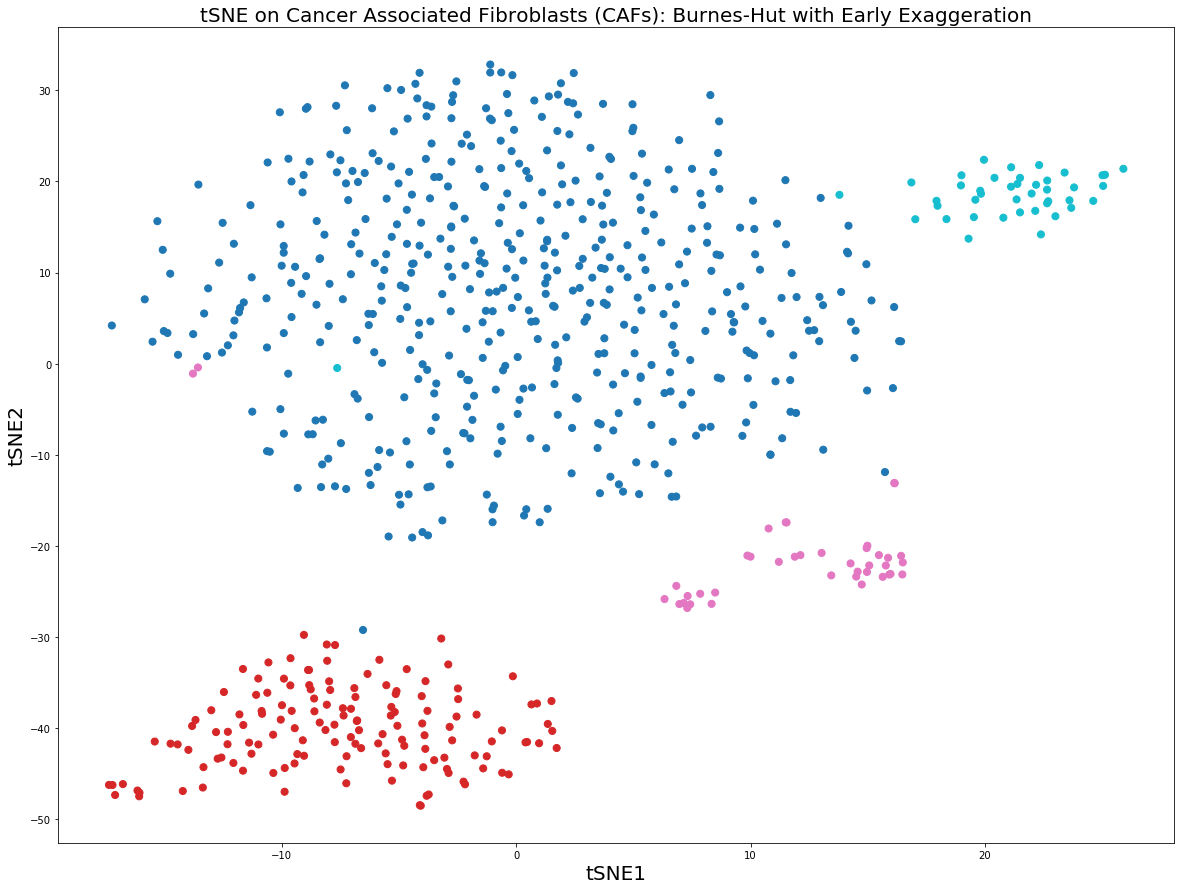

In [17]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate = 100, n_components = 2, random_state = 123, perplexity = 30, verbose=2)
tsne = model.fit_transform(X_train)
plt.figure(figsize=(20, 15))
plt.scatter(tsne[:, 0], tsne[:, 1], c=y_train.astype(int), cmap = 'tab10', s = 50)
plt.title("tSNE on Cancer Associated Fibroblasts (CAFs): Burnes-Hut with Early Exaggeration", fontsize = 20)
plt.xlabel("tSNE1", fontsize = 20); plt.ylabel("tSNE2", fontsize = 20)
plt.show()

Now, in order to reproduce the from scratch implementation, we will use the exact tSNE and swith off the early exaggeration.

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 716 / 716
[t-SNE] Mean sigma: 7.540113
[t-SNE] Iteration 50: error = 1.4848583, gradient norm = 0.0020657 (50 iterations in 0.957s)
[t-SNE] Iteration 100: error = 1.3750211, gradient norm = 0.0009555 (50 iterations in 1.006s)
[t-SNE] Iteration 150: error = 1.3380948, gradient norm = 0.0005748 (50 iterations in 1.008s)
[t-SNE] Iteration 200: error = 1.3188041, gradient norm = 0.0004392 (50 iterations in 1.391s)
[t-SNE] Iteration 250: error = 1.3050413, gradient norm = 0.0003492 (50 iterations in 1.449s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1.305041
[t-SNE] Iteration 300: error = 1.2994059, gradient norm = 0.0002118 (50 iterations in 1.456s)
[t-SNE] Iteration 350: error = 1.2898256, gradient norm = 0.0001655 (50 iterations in 1.172s)
[t-SNE] Iteration 400: error = 1.2823523, gradient norm = 0.0001324 (50 iterations in 1.252s)
[t-SNE] Iteration 450: error = 1.277173

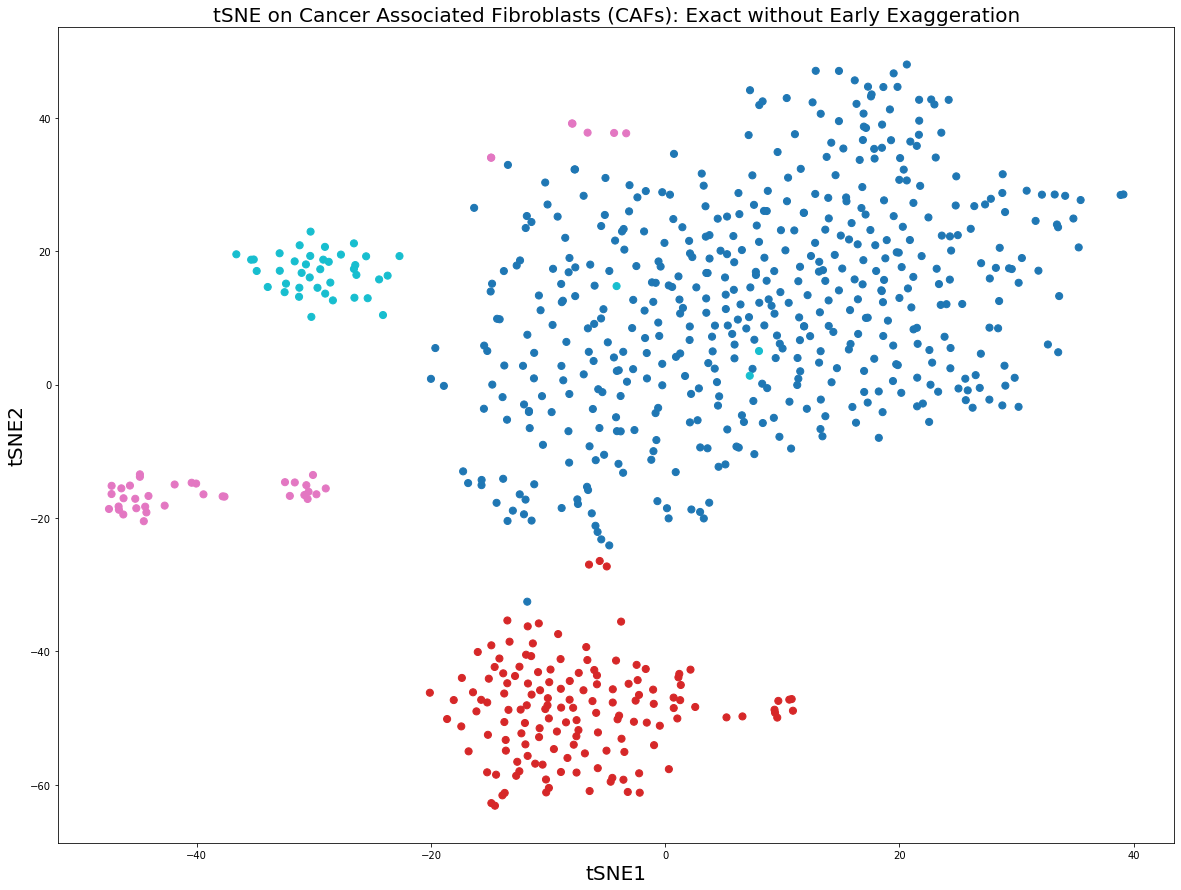

In [18]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate = 100, n_components = 2, 
             random_state = 123, perplexity = 30, early_exaggeration = 1, method = 'exact', verbose = 2)
tsne = model.fit_transform(X_train)
plt.figure(figsize=(20, 15))
plt.scatter(tsne[:, 0], tsne[:, 1], c=y_train.astype(int), cmap = 'tab10', s = 50)
plt.title("tSNE on Cancer Associated Fibroblasts (CAFs): Exact without Early Exaggeration", fontsize = 20)
plt.xlabel("tSNE1", fontsize = 20); plt.ylabel("tSNE2", fontsize = 20)
plt.show()

Now the scattering of the clusters becomes more obvious, this resembles the picture from our from scratch implementation. Please note that the mean sigma was 7.54 while in our implemenattion it was 6.37. This is an interesting discrepancy which should be cleared in the future.

### Key Differences Between tSNE and UMAP <a class="anchor" id="Key-Differences-Between-tSNE-and-UMAP"></a>

My first impression when I heard about UMAP was that it is a new interesting dimensionality reduction method which is based on solid mathematical principles and hence very different from tSNE which is a pure Machine Learning semi-empirical algorithm. My biological friends told me the [original UMAP paper](https://arxiv.org/abs/1802.03426) was "too mathematical", and looking at the Section 2 of the paper I was very happy to see strict and accurate mathematics coming to Life and Data Science. Reading the [UMAP docs](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html) and watching Leland [McInnes talk](https://www.youtube.com/watch?v=nq6iPZVUxZU&t=765s) at SciPy 2018, I got puzzled and felt like UMAP is another neighbor graph technique which is so similar to tSNE that **I was struggling to understand how exactly UMAP is different from tSNE**. 

From the UMAP paper, the differences between UMAP and tSNE are not very visible even though Lelan McInnes tries to summarize them in the Appendix C. I would rather say, I do see small differences but it is not clear why they bring such dammatic effects. Here I will first summarize what I noticed is different between UMAP and tSNE and then try to explain why thsese differences are important and figure out how large their effects are.

* UMAP uses **exponential probability in high dimensions but not necessarily Euclidean distances** like tSNE but rather any distance metrix $d(x_j, x_j)$. In addition, the probabilities are **not normalized**:
$$
p_{i|j} = \displaystyle e^{- \displaystyle \frac{d(x_i, x_j) - \rho_i}{\sigma_i}}
$$
Here $\rho_i$ is a very important parameter that represent the distance from each data point $x_i$ to its first nearest neightbor. This provides the **local connectivity** of the manifold. In other words, this imposes a locally self-adjustable exponential kernel for each data point $x_i$, so the **distance metric varies from point to point**.

* **UMAP does not apply normalization** to either high- or low-dimensional probabilities, which is very different from tSNE and feels weird. However, just from the functional form of the high- or low-dimensional probabilities one can see that they are **already scaled for the segment \[0, 1\]**, so perhaps it is fine to skip normalization. However, it turns out that the lack of normalization, aka denominator in Eq. (1), **dramatically reduces time** of computing the high dimensional graph.

* UMAP uses the **number of nearest neighbors** instead of perplexity. While tSNE defined perplexity as $\rm{Perp} = 2^{H(p_{ij})}, H(p_{ij}) = \sum_i p_{ij}\log_2p_{ij}$, UMAP defines the number of nearest neighbor **k** without the $\log_2$ function, i.e. as follows:
$$
k = 2^{\displaystyle \sum_i p_{ij}}
$$

* UMAP uses slightly different of symmetrization of $p_{i|j}$. The symmterization is necessary since after UMAP glues together points with locally varying metrics, it can happen that weights of the graph between two nodes A and B are $w_{AB} \neq w_{BA}$. Why exactly UMAP uses this kind of symmetrization insread of the one used by tSNE is not clear.
$$
p_{ij} = p_{i|j} + p_{j|i} - p_{i|j}p_{j|i}
$$

* UMAP uses the family of functions $1/(1+ay^{2b})$ for modelling distance probabilities in **low dimensions, not exactly Student t-distribution but very-very similar**, please note that again **no normalization** is applied:
$$
q_{ij} = \left ( 1 + a(y_i - y_j) ^{2b} \right ) ^ {-1},
$$
where $a\approx 1.93$ and $b\approx 0.79$ for default UMAP hyperparameters. In practice, UMAP finds a and b from non-linear least-square fitting:
$$
\left ( 1 + a(y_i - y_j) ^{2b} \right ) ^ {-1} \approx 
\begin{cases}
  1 & \text{if } y_i - y_j\le \rm{min\_dist}\\    
  e^{\displaystyle -(y_i - y_j) - \rm{min\_dist}} & \text{if } y_i - y_j > \rm{min\_dist}  
\end{cases}
\hspace{2em} (5)
$$
To understand better how the family of curves $1/(1+ay^{2b})$ behaves let us plot a few:

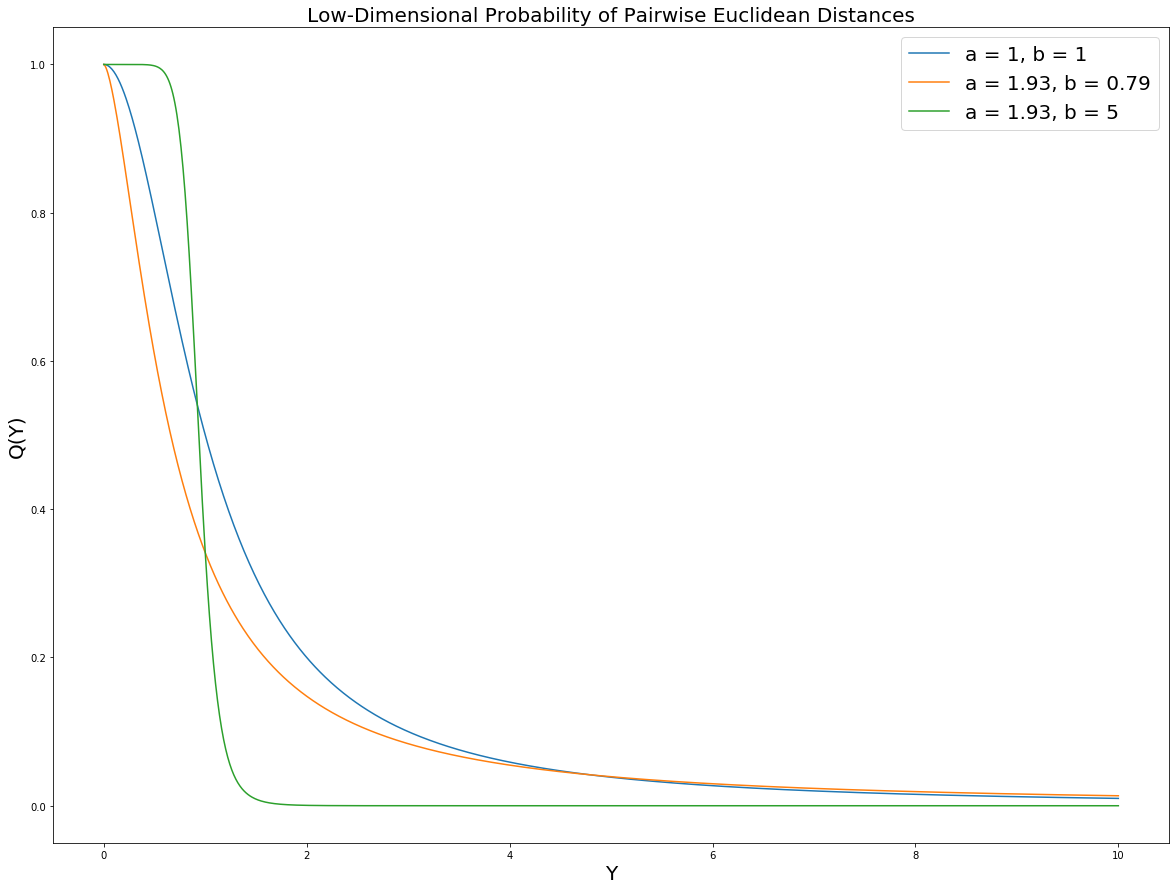

In [29]:
plt.figure(figsize=(20, 15))
y = np.linspace(0, 10, 1000)

my_prob = lambda y, a, b: np.power(1 + a*y**(2*b), -1)
plt.plot(y, my_prob(y, a = 1, b = 1))
plt.plot(y, my_prob(y, a = 1.93, b = 0.79))
plt.plot(y, my_prob(y, a = 1.93, b = 5))

plt.gca().legend(('a = 1, b = 1', 'a = 1.93, b = 0.79', 'a = 1.93, b = 5'), fontsize = 20)
plt.title("Low-Dimensional Probability of Pairwise Euclidean Distances", fontsize = 20)
plt.xlabel("Y", fontsize = 20); plt.ylabel("Q(Y)", fontsize = 20)
plt.show()

We can see that the family of curves is very sensitive to the parameter b, at large b it forms a sort of plateau at small Y. This implies that below UMAP hyperparameter **min_dist** all data points are equally tightly connected. Since the Q(Y) function behaves almost like a [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) it means that UMAP assigns almost the same low-dimensional coordiante for all points that are close to each other in the low-dimensional space. The **min_dist** is exactly what leads to the **super-tightly packed clusters** often observed in UMAP dimensionality reduction plots.

To demonstrate how exactly the fit from Eq. (5) looks like, let us display a simple piecewise function (where the plateau is defined by the **min_dist** parameter) and fit it using the family of functions $1/(1+ay^{2b})$ via optimize.curve_fit from scipy python library. As a result of the fit, we obtain the optial **a** and **b** parameters for the function $1/(1+ay^{2b})$.

[0.12015106 1.88131742]


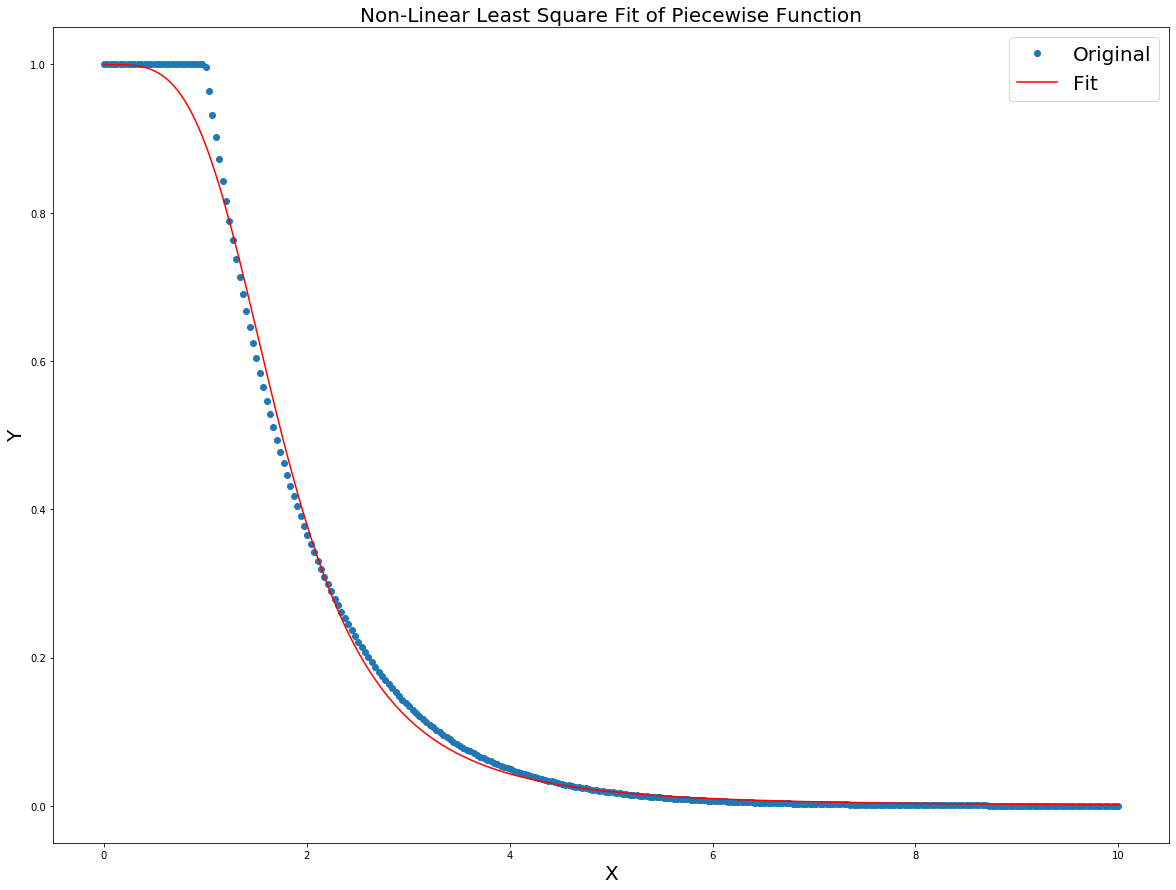

In [51]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

MIN_DIST = 1

x = np.linspace(0, 10, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))
    
p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))
print(p)

plt.figure(figsize=(20,15))
plt.plot(x, f(x, MIN_DIST), "o")
plt.plot(x, dist_low_dim(x, p[0], p[1]), c = "red")
plt.title("Non-Linear Least Square Fit of Piecewise Function", fontsize = 20)
plt.gca().legend(('Original', 'Fit'), fontsize = 20)
plt.xlabel("X", fontsize = 20)
plt.ylabel("Y", fontsize = 20)
plt.show()

* UMAP uses **binary cross-entropy (CE)** as a cost function instead of the KL-divergence like tSNE does. 
$$
CE (X, Y) = \sum_i \sum_j \left[ p_{ij}(X) \log \left(\frac {p_{ij}(X)} {q_{ij}(Y)}\right) + \left(1- p_{ij}(X)\right) \log \left(\frac {1 - p_{ij}(X)} {1 - q_{ij}(Y)}\right) \right]
$$
In the next session we will show that the additional (second) term in the CE cost function makes UMAP capable of capturing the global structure in contrast to tSNE that can only preserve the local structure at moderate perplexity values. An interesting question to ask is why UMAP uses exactly **binary** cross-entropy, which is usually used for classification problems with binary (aka "cats" vs. "dogs") outcome. Here we are classifying anything and moreovere it is not a binary classification problem.

Since we need to know the gradient of the cross-entropy in oder to implement the Gradient Descent, let us quickly calculate it. Ignoring the constant terms containing only $p_{ij}(X)$ we can rewrite the cross-entropy and differentiate it as follows:

$$
CE(X, d_{ij}) = \sum_j \left[ -P(X)\log Q(d_{ij}) + \left(1-P(X)\right)\log\left(1 - Q(d_{ij})\right)\right], \hspace{2em}\text{where } d_{ij} = y_i - y_j
$$
$$
Q(d_{ij}) = \frac{1}{1 + a d_{ij}^{2b}}; \hspace{2em} 1 - Q(d_{ij}) = \frac{a d_{ij}^{2b}}{1 + a d_{ij}^{2b}}; \hspace{2em} \frac{\delta Q}{\delta d_{ij}} = -\frac{2ab d_{ij}^{2b-1}}{\left(1 + a d_{ij}^{2b}\right)^2}
$$
$$
\frac{\delta CE}{\delta y_i} = \sum_j \left[ -\frac{P(X)}{Q(d_{ij})}\frac{\delta Q}{\delta d_{ij}} + \frac{1 - P(X)}{1 - Q(d_{ij})}\frac{\delta Q}{\delta d_{ij}} \right] = \sum_j \left[ \left(-P(X)\left(1 + a d_{ij}^{2b}\right) + \frac{(1-P(X))\left(1 + a d_{ij}^{2b}\right)}{\left(a d_{ij}^{2b}\right)} \right)\frac{\delta Q}{\delta d_{ij}} \right]
$$
$$
\frac{\delta CE}{\delta y_i} = \sum_j \left[ \frac{2abd_{ij}^{2(b-1)}P(X)}{1 + a d_{ij}^{2b}} - \frac{2b(1-P(X))}{d_{ij}^2(1 + a d_{ij}^{2b})} \right]\left(y_i - y_j\right) \hspace{2em} (6)
$$

* UMAP assigns initial low-dimensional coordiantes using **Graph Laplacian** in contrast to **random normal initialization** used by tSNE. This however should make a minor effect on the final low-dimensional representation, this was at least [the case for tSNE](https://jlmelville.github.io/smallvis/init.html). However, this should make UMAP less changing from run to run since it is not a random initialization anymore. The choice of initialization via Graph Laplacian is motivated by the [hypothesis of Linderman and Steinerberger](https://arxiv.org/pdf/1706.02582.pdf) who suggested that **minimzation of KL-divergence in the initial stage with early exxageration is equivalent to constructing the Graph Laplacian**. 

Graph Laplacian, Spectral Clustering, Laplacian Eignemaps, Diffusion Maps, Spectral Embedding etc. refer to practically the same interesting methodology that combines **Matrix Factorization and Neighbor Graph** approaches to the Dimensionality Reduction problem. In this methodology, we start with constructing a graph (or knn-graph) and formalize it with matrix algebra (**adjucency and degree matrices**) via constructing the Laplacian matrix, finally we factorize the Laplacian matrix, i.e. solving **eigen-decomposition problem**.

$$
L = D^{1/2}\left(D - A\right)D^{1/2}
$$

We can use scikit-learn Python library and easily display the initial low-dimensional coordinates using the SpectralEmbedding function:

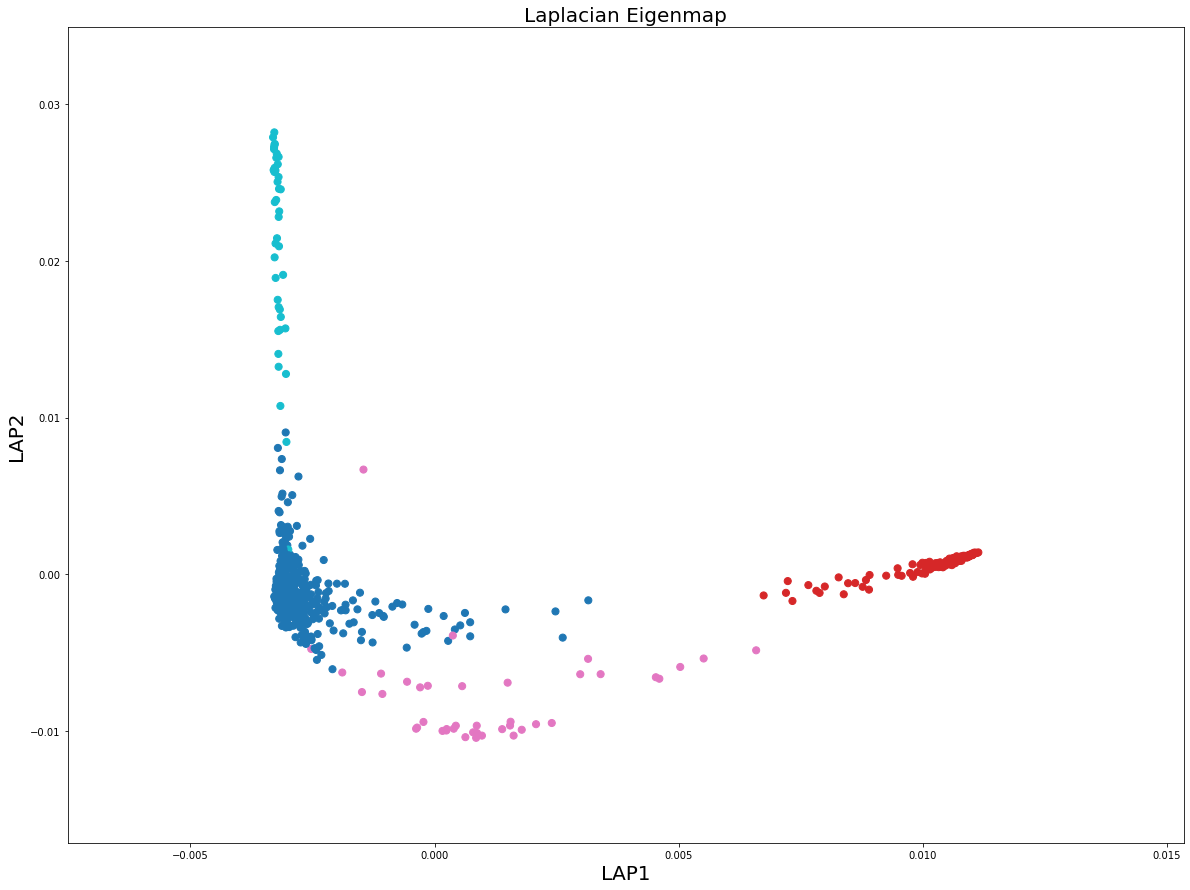

In [38]:
from sklearn.manifold import SpectralEmbedding
model = SpectralEmbedding(n_components = 2, n_neighbors = 50)
se = model.fit_transform(np.log(X_train + 1))
plt.figure(figsize=(20,15))
plt.scatter(se[:, 0], se[:, 1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title('Laplacian Eigenmap', fontsize = 20)
plt.xlabel("LAP1", fontsize = 20)
plt.ylabel("LAP2", fontsize = 20)
plt.show()

### Why tSNE Preserves Only Local Structure?  <a class="anchor" id="Why-tSNE-Preserves-Only-Local-Structure?"></a>

Now let us briefly discuss why exactly they say that tSNE preserves only local structure of the data. Locality of tSNE can be understood from different points of view. First we have the $\sigma$ parameter in Eq. (1) which sets how locally our data points "feel" each other. Since the probability of pairwise Euclidean distances decays exponentially, at small values of $\sigma$, it is basically zero for distant points (large X) and grows dramatically fast only for nearest neighbors (small X). In contrast, at large $\sigma$, the probabilities for distant and close points become comparable and in the limit $\sigma\rightarrow \infty$, the probability becomes equal to 1 for all distances between any pair of points, i.e. points become equidistant.

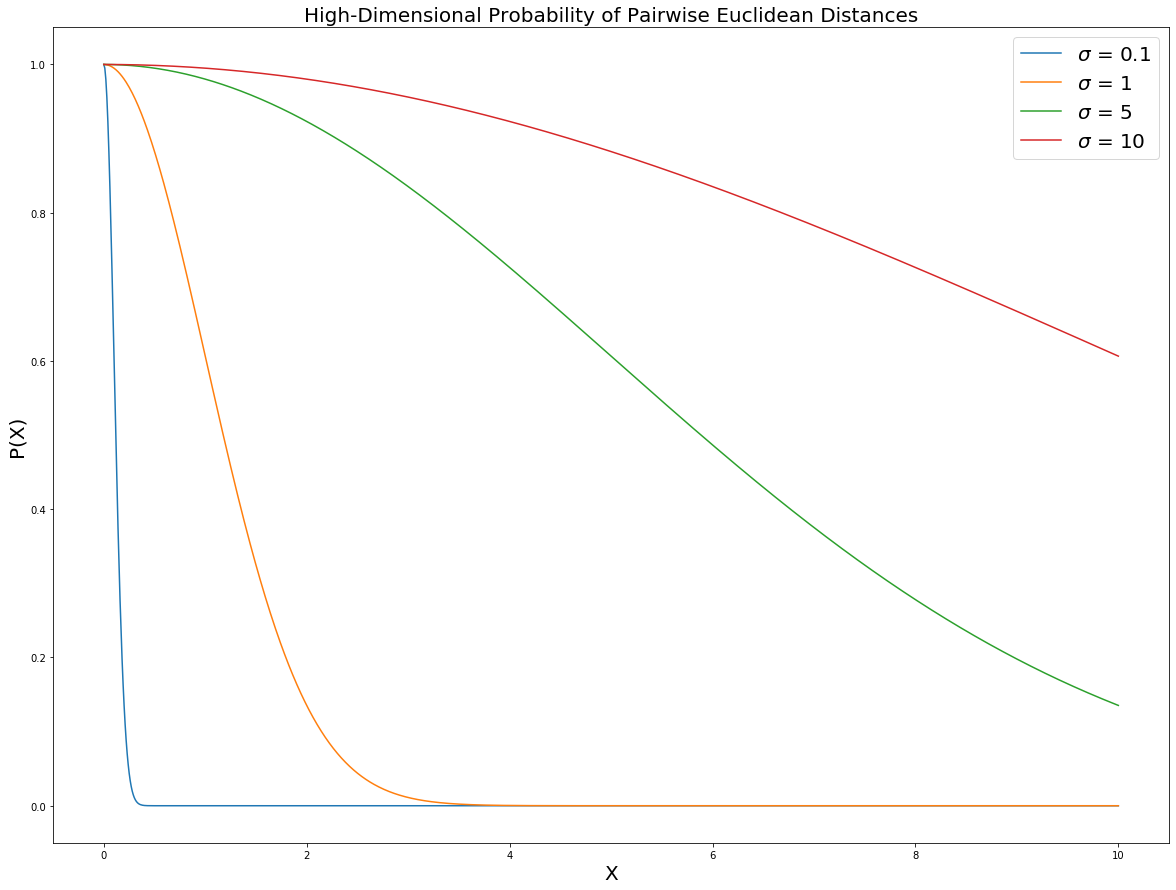

In [43]:
plt.figure(figsize=(20, 15))
x = np.linspace(0, 10, 1000)
sigma_list = [0.1, 1, 5, 10]

for sigma in sigma_list:
    my_prob = lambda x: np.exp(-x**2 / (2*sigma**2))
    plt.plot(x, my_prob(x))
plt.gca().legend(('$\sigma$ = 0.1','$\sigma$ = 1', '$\sigma$ = 5', '$\sigma$ = 10'), fontsize = 20)
plt.title("High-Dimensional Probability of Pairwise Euclidean Distances", fontsize = 20)
plt.xlabel("X", fontsize = 20); plt.ylabel("P(X)", fontsize = 20)
plt.show()

Interestingly, if we expand the probability of pairwise Euclidean distances in high dimensions into Taylor series at $\sigma\rightarrow \infty$, we will get the power law in the second approximation:

$$
P(X) \approx \displaystyle e^{\displaystyle -\frac{X^2}{2\sigma^2}}
$$

$$
P(X) \underset{\displaystyle\sigma\rightarrow \infty}{\longrightarrow} 1 - \frac{X^2}{2\sigma^2} + \frac{X^4}{8\sigma^4} - \dots \hspace{2em} (7)
$$

The power law with respect to the pairwise Euclidean distances resembles the cost function for the [Multi-Dimensional Scaling (MDS)](https://en.wikipedia.org/wiki/Multidimensional_scaling) which is known to preserve global distances by trying to preserve distances between each pair of points regardless whether they are far apart or close to each other. One can interpret this in a way that **at large $\sigma$ tSNE does account for long-range interactions between the points, so it is not entirely correct to say that tSNE can handle only local distances**. However, we usually restrict ourselves by finite values of perplexity, Laurens van der Maaten recommends [perplexity values between 5 and 50](https://lvdmaaten.github.io/tsne/#faq), although perhaps a good compromise between local and global information would be to select perplexity approximately following [the square root law  $\approx N^{1/2}$](https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868), where N is the sample size.

On the other hand, $\sigma\rightarrow 0$ results in extreme "locality" in the behavior of the high dimensional probability which resembles the **Dirac delta-function** behavior.

$$
P(X) \underset{\displaystyle\sigma\rightarrow 0}{\longrightarrow} \delta_{\sigma}(X) \hspace{2em} (8)
$$

Another way to understand "locality" of tSNE is to think about the KL-divergance function. Let us try to plot it assuming **X** is a distance between points in high-dimensional space and **Y** is a low-dimensional distance:

$$
P(X) \approx e^{\displaystyle - X^2} \hspace{2em} Q(Y) \approx \frac{1}{1+Y^2}
$$

From the definition of the KL-divergence, Eq. (4):

$$
KL(X,Y) = P(X)\log\left(\frac{P(X)}{Q(Y)}\right) = P(X)\log P(X) - P(X)\log Q(Y) \hspace{2em} (9)
$$

The first term in Eq. (9) is close to zero for both large and small X. It goes to zero for small X since the exponent becomes close to 1 and $\log (1) = 0$. For large X this term still goes to zero because the exponential pre-factor goes faster to zero than the logarith goes to $- \infty$. Therefore, for intuitive understanding of the KL-divergence it is enough to to consider only the second term:

$$
KL(X,Y) \approx - P(X)\log Q(Y) = e^{\displaystyle - X^2} \log \left(1 + Y^2\right)
$$

This is a weird looking function, let us plot KL(X, Y):

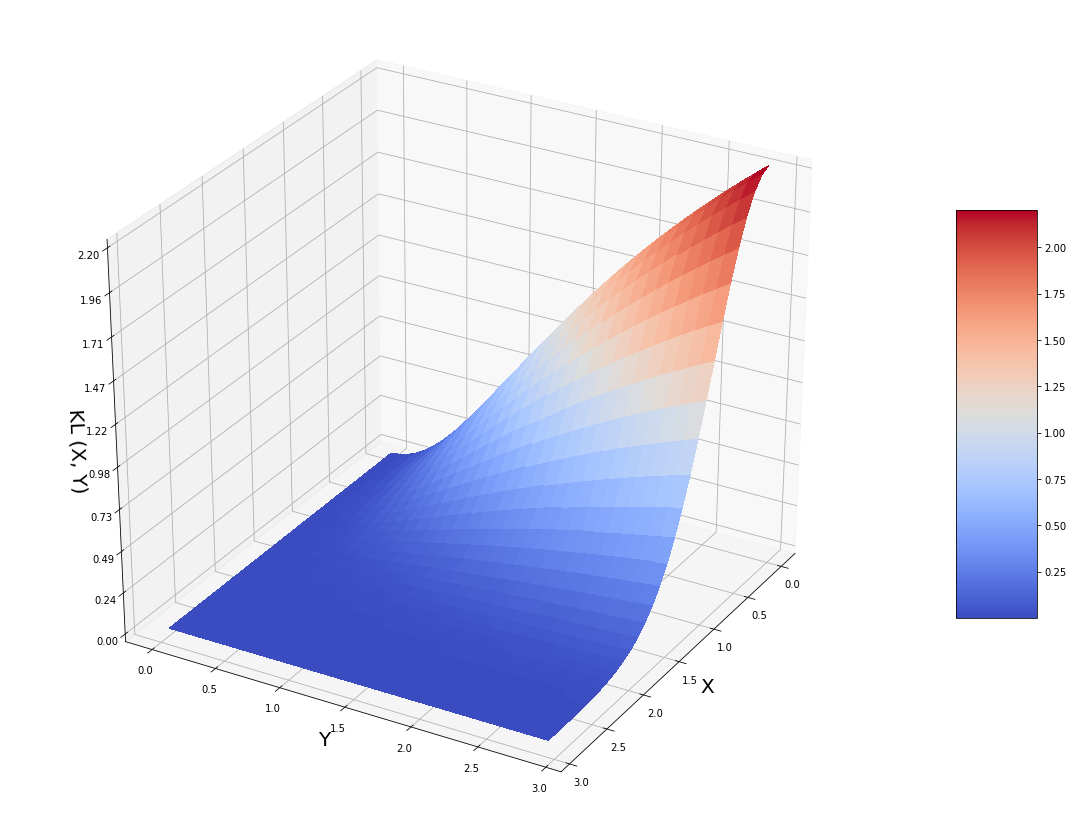

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(20, 15))
ax = fig.gca(projection = '3d')
# Set rotation angle to 30 degrees
ax.view_init(azim=30)

X = np.arange(0, 3, 0.1)
Y = np.arange(0, 3, 0.1)
X, Y = np.meshgrid(X, Y)
Z = np.exp(-X**2)*np.log(1 + Y**2)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('X', fontsize = 20)
ax.set_ylabel('Y', fontsize = 20)
ax.set_zlabel('KL (X, Y)', fontsize = 20)
ax.set_zlim(0, 2.2)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

The function has a very asymmetric shape. If the distance between the points in high dimensions **X is small**, the exponential prefactor is 1 and the logarithmic term behaves as $\log \left(1 + Y^2\right)$ meaning that if the distance in low dimensions Y is large as well, there will be a **high penatly**, therefore **tSNE tries to reduce Y at small X in order to reduce the penalty**. However, for large distances X in high dimensions, Y can be basically any value from 0 to $\infty$ since the exponential term goes to zero and always wins over the logarithmic term. Therefore **it might happen that points far apart in high dimensions end up close to each other in low dimensions**. In other words, tSNE does not guarantee that points far apart in high dimensions will be preserved to be far apart in low dimensions. However, it does guarantee that points close to each other in high dimensions will remain close to each other in low dimensions. So tSNE is not really good at projecting large distances into low dimensions, so **it preserves only the local data structure provided that $\sigma$ does not go to $\infty$**.

### Why UMAP Can Preserve Global Structure  <a class="anchor" id="Why-UMAP-Can-Preserve-Global-Structure"></a>

In contrast to tSNE, UMAP uses Cross-Entropy (CE) as a cost function instead of the KL-divergence:

$$
CE(X,Y) = P(X)\log\left(\frac{P(X)}{Q(Y)}\right) + \left(1-P(X)\right)\log\left(\frac{1-P(X)}{1-Q(Y)}\right)
$$

$$
CE(X, Y) = e^{\displaystyle - X^2} \log \left[e^{\displaystyle - X^2}\left(1 + Y^2\right)\right] + \left(1 - e^{\displaystyle - X^2}\right) \log \left[\frac{\left(1-e^{\displaystyle - X^2}\right)\left(1 + Y^2\right)}{Y^2}\right]\\ \approx e^{\displaystyle - X^2} \log \left(1 + Y^2\right) + \left(1-e^{\displaystyle - X^2}\right) \log \left(\frac{1 + Y^2}{Y^2}\right)
$$

This leads to dramatic changes in the local-global structure preservation balance. At small values of **X** we get the same limit as for tSNE since the second term disappears because of the prefactor and the fact that log-function is slower than polynomial function:

$$
X\rightarrow 0: CE(X, Y) \approx \log \left(1 + Y^2\right)
$$

therefore the **Y** coordinates are forced to be samll, i.e. $Y\rightarrow 0$, in order to minimize the penalty. This is exactly like tSNE behaves.

However, in the opposite limit of large **X**, i.e. $X\rightarrow\infty$, the first term disapperas, prefactor of the second term becomes 1 and we obtain:

$$
X\rightarrow \infty: CE(X, Y) \approx \log \left(\frac{1 + Y^2}{Y^2}\right)
$$

Here if **Y** is small, we get a high penalty because of the **Y** in the denominator of the logarithm, therefore **Y** is encouraged to be large so that the ratio under logarithm becomes 1 and we get zero penalty. Therefore we get $Y\rightarrow \infty$ at $X\rightarrow \infty$, so the global distances are preserved wehn moving from high- to low-dimensional space, exactly what we want.

To demonstrate this, let us plot the UMAP CE cost function:

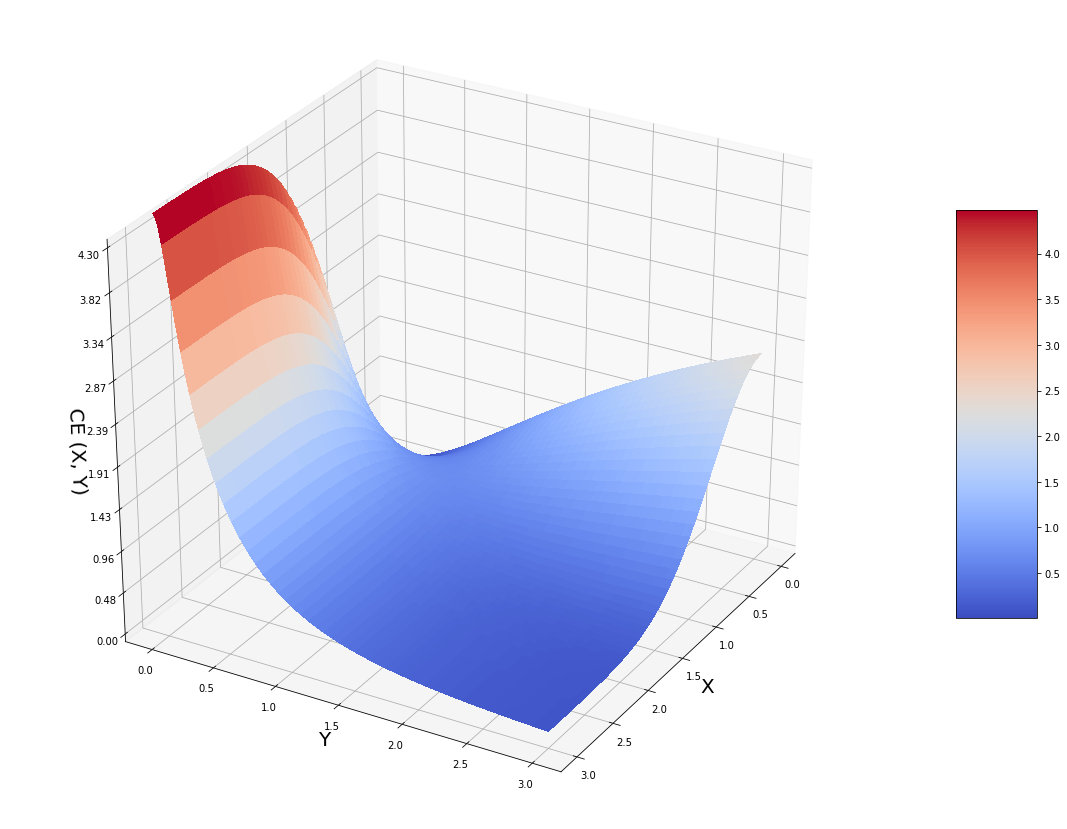

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(20, 15))
ax = fig.gca(projection = '3d') 
# Set rotation angle to 30 degrees
ax.view_init(azim=30)

X = np.arange(0, 3, 0.001)
Y = np.arange(0, 3, 0.001)
X, Y = np.meshgrid(X, Y)
Z = np.exp(-X**2)*np.log(1 + Y**2) + (1 - np.exp(-X**2))*np.log((1 + Y**2) / (Y**2+0.01))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('X', fontsize = 20)
ax.set_ylabel('Y', fontsize = 20)
ax.set_zlabel('CE (X, Y)', fontsize = 20)
ax.set_zlim(0, 4.3)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Here we see that the "right" part of the plot looks fairly similar to the KL-divergence surface above. Meaning that at low **X** we still want to have low **Y** in order to reduce the penalty. However, at large **X** the **Y** distance really wants to be large as well because if it is small, the CE (X, Y) penalty will be enormous. Remember, previously, for KL (X, Y) surface, we did not have any difference in penalty between low and high **Y** at large **X**. That is why CE (X, Y) cost function is capable of preserving global distances as well as local distances.

### Programming UMAP from Scratch <a class="anchor" id="Programming-UMAP-from-Scratch"></a>

Now when we have learnt how to program tSNE from scratch and understood the key differences between tSNE and UMAP, let us make the next step and try to implement the UMAP algorithm from scratch by modifying the tSNE code.

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import euclidean_distances

path = '/home/nikolay/WABI/K_Pietras/Manifold_Learning/'
expr = pd.read_csv(path + 'bartoschek_filtered_expr_rpkm.txt', sep='\t')
print(expr.iloc[0:4,0:4])
X_train = expr.values[:,0:(expr.shape[1]-1)]
X_train = np.log(X_train + 1)
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = expr.values[:,expr.shape[1]-1]
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)

                1110020A21Rik  1110046J04Rik  1190002F15Rik  1500015A07Rik
SS2_15_0048_A3            0.0            0.0            0.0            0.0
SS2_15_0048_A6            0.0            0.0            0.0            0.0
SS2_15_0048_A5            0.0            0.0            0.0            0.0
SS2_15_0048_A4            0.0            0.0            0.0            0.0

This data set contains 716 samples

Dimensions of the  data set: 
(716, 557) (716,)


In [2]:
dist = np.square(euclidean_distances(X_train, X_train))
rho = [sorted(dist[i])[1] for i in range(dist.shape[0])]
print(dist[0:4, 0:4])
print('\n')
print(rho[0:4])

[[   0.          914.95016311 1477.46836099 3036.91172176]
 [ 914.95016311    0.         1307.39294642 2960.41559961]
 [1477.46836099 1307.39294642    0.         2678.34442573]
 [3036.91172176 2960.41559961 2678.34442573    0.        ]]


[805.2464562222542, 652.4022952321459, 1036.9011547563534, 1244.8783774968015]


In [3]:
def prob_high_dim(sigma, dist_row):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    d = dist[dist_row] - rho[dist_row]
    d[d < 0] = 0
    return np.exp(- d / sigma)

def k(prob):
    """
    Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, np.sum(prob))

def sigma_binary_search(k_of_sigma, fixed_k):
    """
    Solve equation k_of_sigma(sigma) = fixed_k 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

N_NEIGHBOR = 15
prob = np.zeros((n,n))
sigma_array = []
for dist_row in range(n):
    func = lambda sigma: k(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOR)
    prob[dist_row] = prob_high_dim(binary_search_result, dist_row)
    sigma_array.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array)))

Sigma binary search finished 100 of 716 cells
Sigma binary search finished 200 of 716 cells
Sigma binary search finished 300 of 716 cells
Sigma binary search finished 400 of 716 cells
Sigma binary search finished 500 of 716 cells
Sigma binary search finished 600 of 716 cells
Sigma binary search finished 700 of 716 cells

Mean sigma = 63.51506110676174


In [4]:
#P = prob + np.transpose(prob) - np.multiply(prob, np.transpose(prob))
P = (prob + np.transpose(prob)) / 2

In [5]:
MIN_DIST = 0.25

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

Hyperparameters a = 1.121436342369708 and b = 1.057499876613678


In [6]:
a = 1
b = 1

In [7]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances
def CE(P, Y):
    """
    Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

def CE_gradient(P, Y):
    """
    Compute the gradient of Cross-Entropy (CE)
    """
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact = np.expand_dims(a * P * (1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

In [8]:
N_LOW_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 200

np.random.seed(12345)
model = SpectralEmbedding(n_components = N_LOW_DIMS, n_neighbors = 50)
y = model.fit_transform(np.log(X_train + 1))
#y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))

CE_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * CE_gradient(P, y)
    
    plt.figure(figsize=(20,15))
    plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
    plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
    plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
    plt.savefig('UMAP_Plots/UMAP_iter_' + str(i) + '.png')
    plt.close()
    
    CE_current = np.sum(CE(P, y)) / 1e+5
    CE_array.append(CE_current)
    if i % 10 == 0:
        print("Cross-Entropy = " + str(CE_current) + " after " + str(i) + " iterations")

Running Gradient Descent: 

Cross-Entropy = 23.04503630924068 after 0 iterations
Cross-Entropy = 1.8226558315570531 after 10 iterations
Cross-Entropy = 1.207840181936309 after 20 iterations
Cross-Entropy = 1.0682100907122891 after 30 iterations
Cross-Entropy = 1.0164973694268917 after 40 iterations
Cross-Entropy = 1.011561221709064 after 50 iterations
Cross-Entropy = 0.9538214033668194 after 60 iterations
Cross-Entropy = 0.9433528207797233 after 70 iterations
Cross-Entropy = 0.9416614802362373 after 80 iterations
Cross-Entropy = 0.9626974591099209 after 90 iterations
Cross-Entropy = 0.9615534919051384 after 100 iterations
Cross-Entropy = 0.946886988838549 after 110 iterations
Cross-Entropy = 0.9297179802238364 after 120 iterations
Cross-Entropy = 0.9504462383367215 after 130 iterations
Cross-Entropy = 0.9543753724576727 after 140 iterations
Cross-Entropy = 0.9335957389472784 after 150 iterations
Cross-Entropy = 0.9716062892397783 after 160 iterations
Cross-Entropy = 0.9513183667597306 

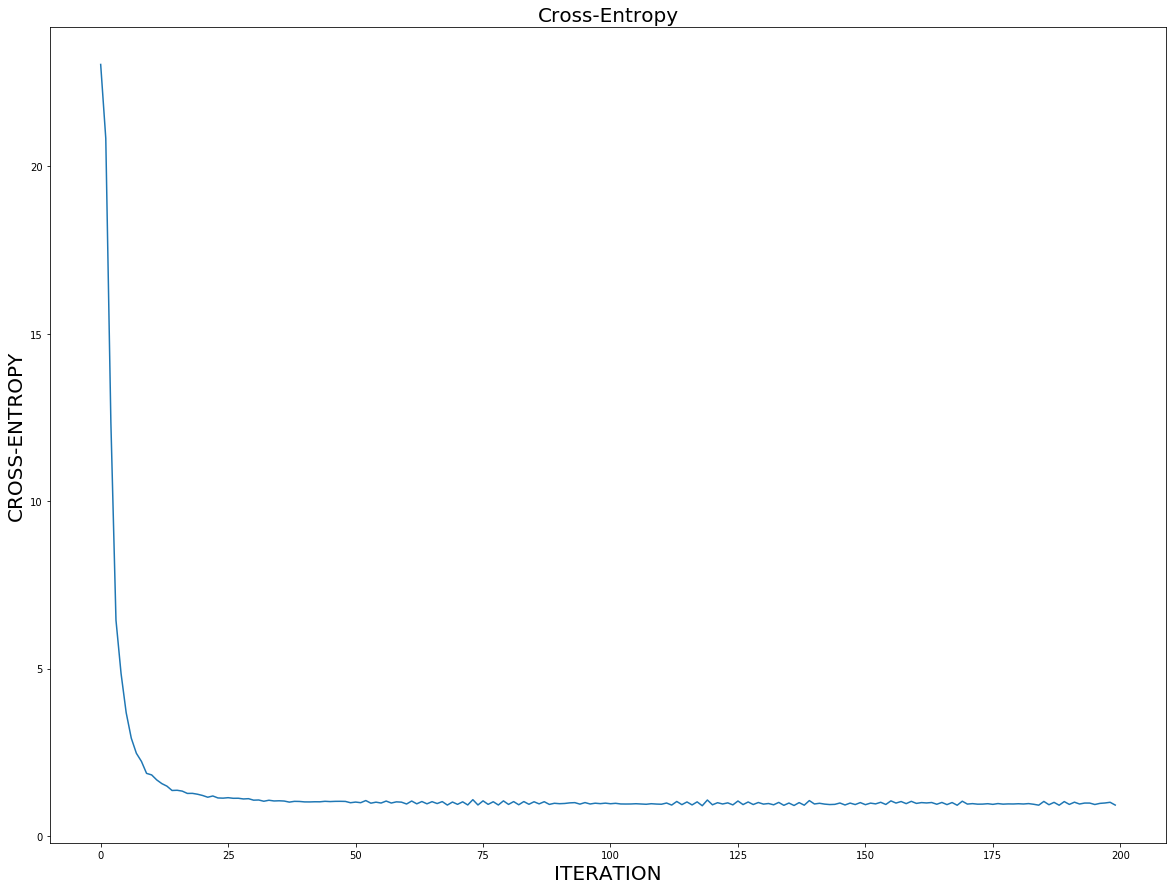

In [9]:
plt.figure(figsize=(20,15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("CROSS-ENTROPY", fontsize = 20)
plt.show()

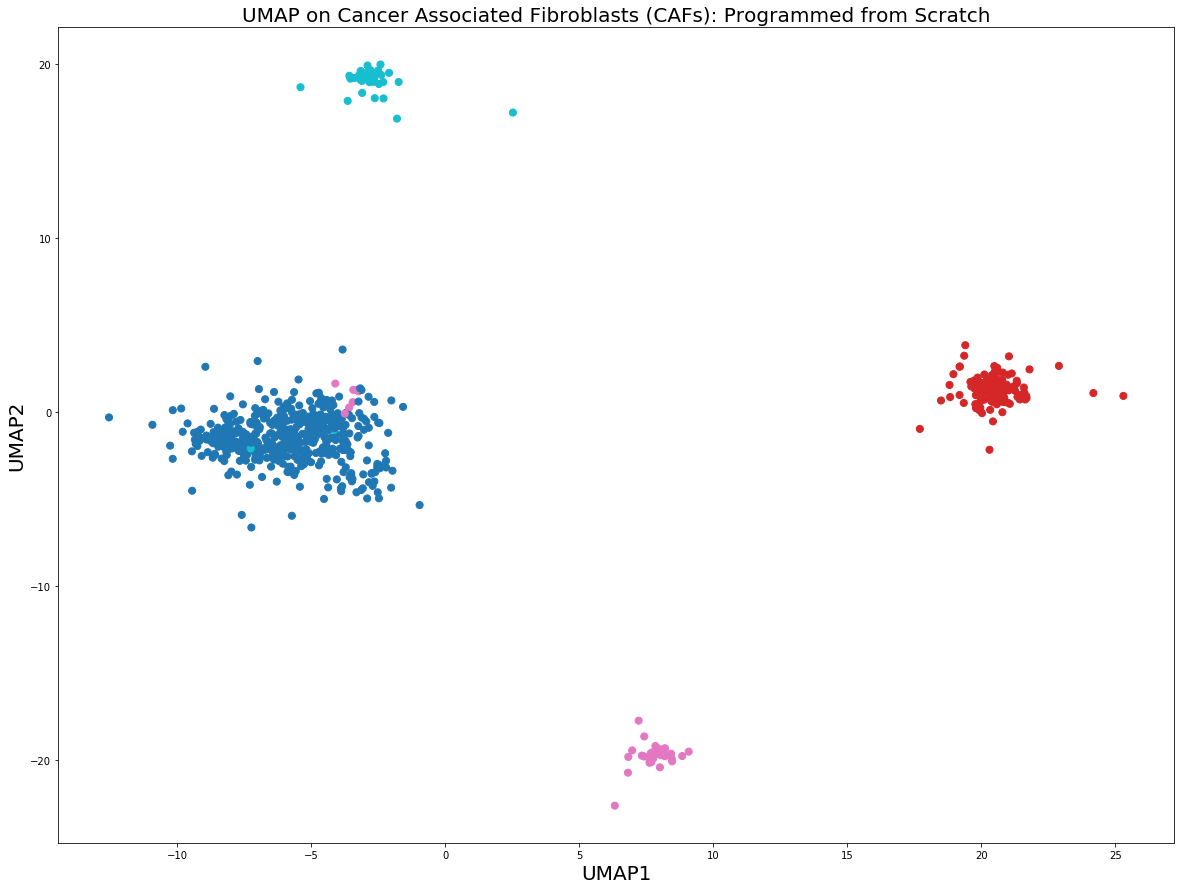

In [10]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
plt.show()

We can see distinct and tight clusters similar to what it looks like at a UMAP plot. Moreover, these cell populations are super-easy to cluster now with any cluster algorithm, perferably graph-based or density-based, however even K-means or Gaussian Mixture Model (GMM) would do a good job on such a clear dimension reduction plot. Let us animate the clustering process in order to see how the points groups into the clusters:

In [ ]:
#%%bash
#convert -delay 0 $(for i in $(seq 0 1 20; seq 21 10 199); do echo UMAP_iter_${i}.png; done) \
#-loop 0 UMAP_animated.gif

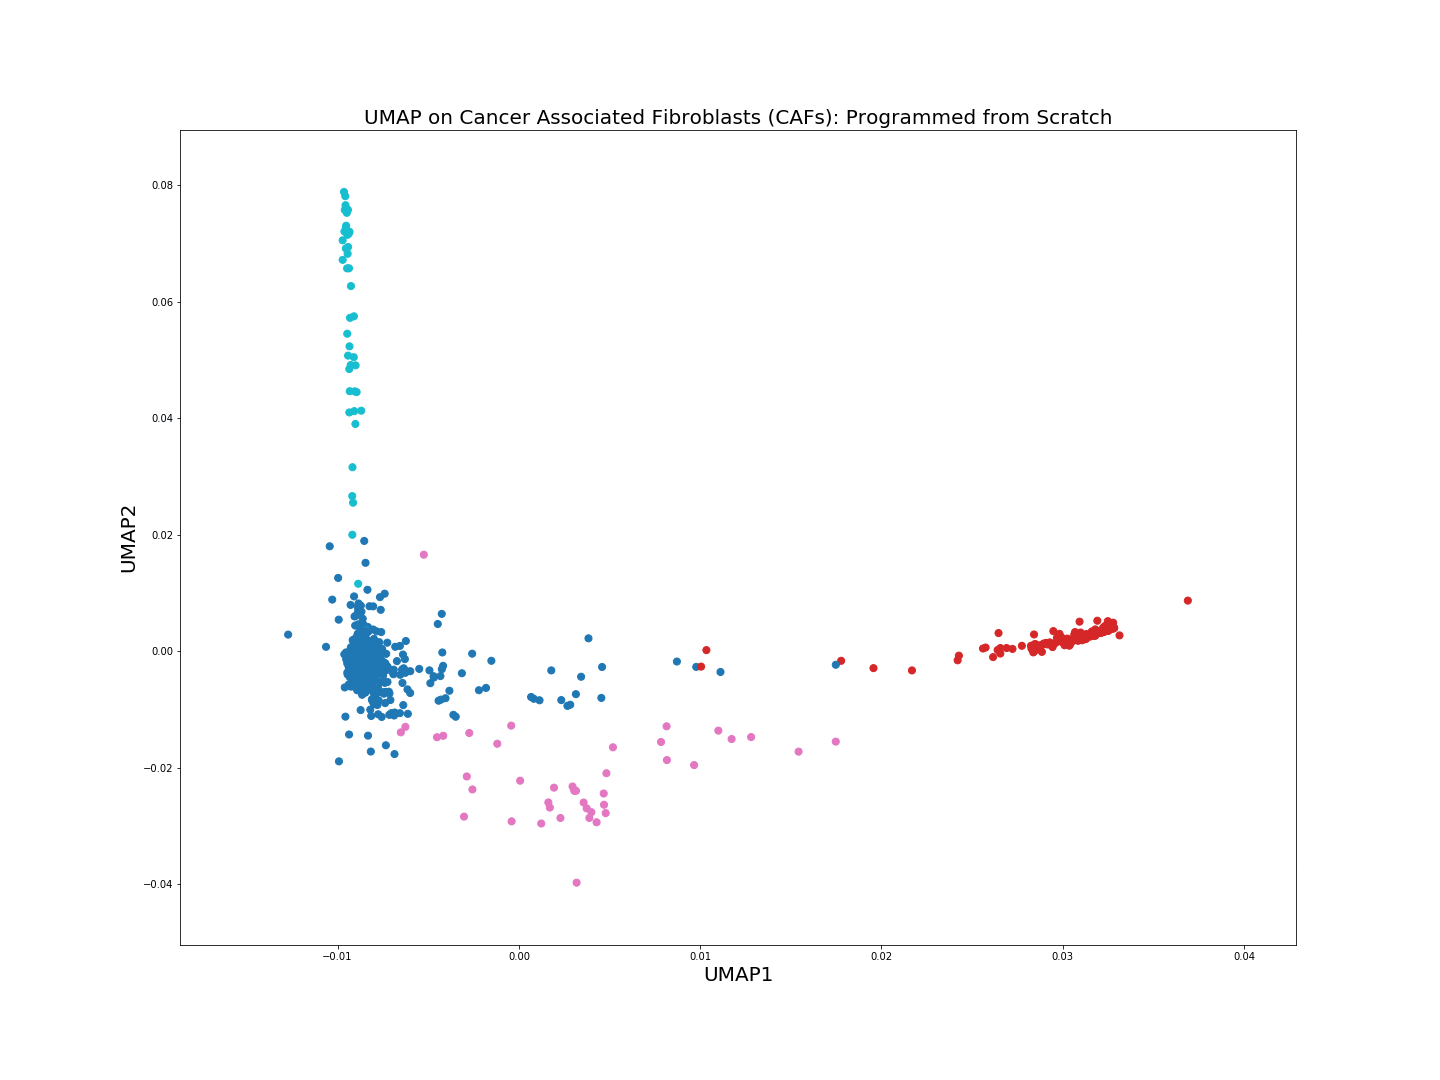

In [11]:
from IPython.display import Image
Image('/home/nikolay/Documents/Jupyter_Notebooks/UMAP_Plots/UMAP_animated.gif.png', width=2000)

For comparison let us use the original Leland McInnes Python implementation of UMAP with identical hyperparameters in oder to compare it with our "from scratch" UMAP implementation:

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.25, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Tue Oct  1 12:14:08 2019 Finding Nearest Neighbors
Tue Oct  1 12:14:08 2019 Finished Nearest Neighbor Search
Tue Oct  1 12:14:12 2019 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Oct  1 

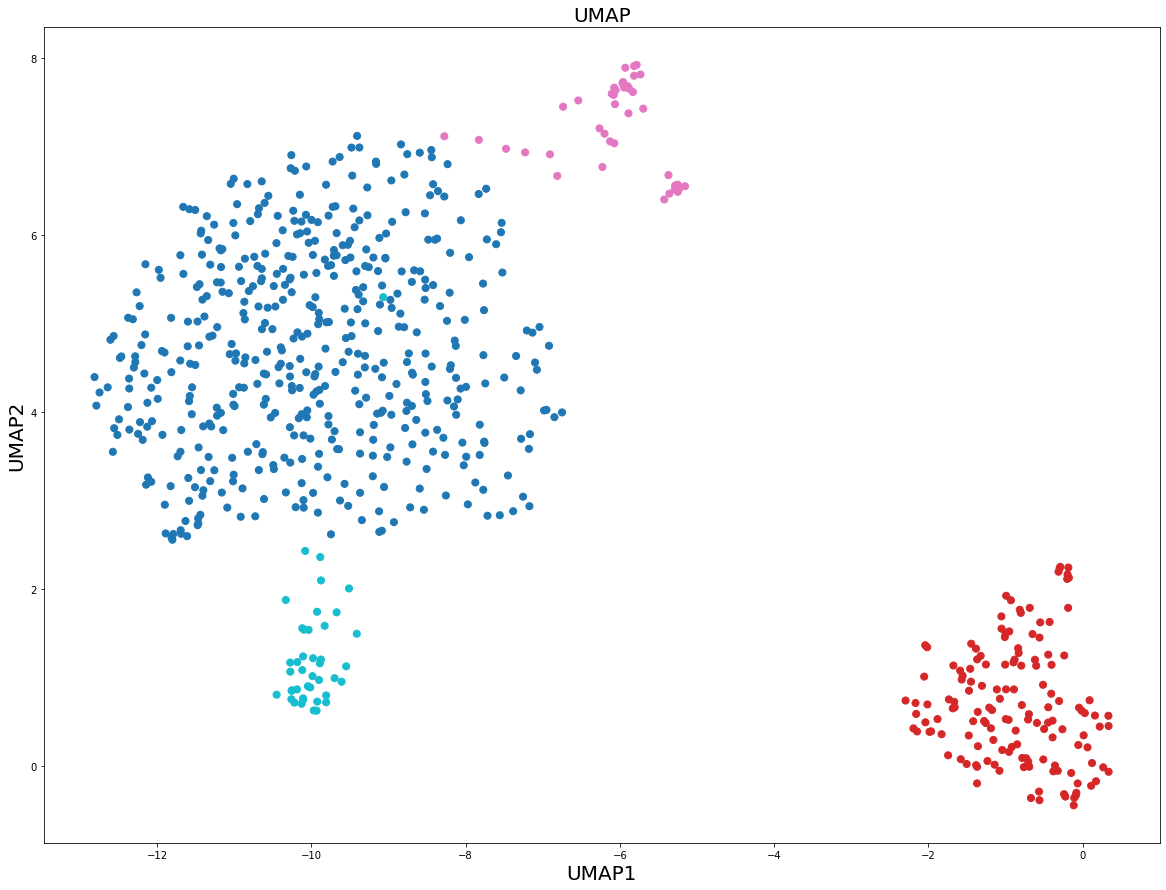

In [11]:
from umap import UMAP
plt.figure(figsize=(20,15))
model = UMAP(n_neighbors = 15, min_dist = 0.25, n_components = 2, verbose = True)
umap = model.fit_transform(X_train)
plt.scatter(umap[:, 0], umap[:, 1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()

We conclude that the original UMAP implementation from Leland McInnes looks quite similar to our "from scratch" implementation. In a sense, the clusters in our dimension reduction look even more distinct. This slight "otperformance" of original UMAP was achieved by setting **a = 1** and **b = 1** like for Student t-distribution and **using the tSNE symmetrization, Eq. (1),** and not the symmetrization with the Hadamard product from the UMAP algorithm.

My prediction is that UMAP is just the beginning, **in the future there will be more and better dimension reduction techniques** because it is quite straightforward to tune low/high dimensional distributions, make better normalizations, better cost functions and play with attractive/repulsive forces for the N-body problem in order to get even better low-dimensional representations. I expect to have an avelanche of such techniques for the Single Cell research area because **even I can improve UMAP low-dimensional representation making small modifications**. If I can do it, many people should be able to doit, so there are more dimensions reduction techniques to come.

### Why Exactly UMAP is Faster than tSNE <a class="anchor" id="Why-Exactly-UMAP-is-Faster-than-tSNE"></a>

We know that **UMAP is faster than tSNE** when it concerns **a) large number of samples, b) number of embedding dimensions greater than 2-3, c) large number of ambient dimensions** in the original data set. Let us try to understand how superiority of UMAP over tSNE comes from the math and algoruthmic implementation.

Both tSNE and UMAP essentially consist of two steps. 

* Building a graph in high dimensions and determining the bandwidth of the exponential probability, $\sigma$, using binary search and the fixed number of nearest neighbors to consider.

* Optimization of low-dimensional embeddings via Gradient Descent. The second step is the bottleneck of the algorithm, it is consequtive and [can not be multi-threaded](https://github.com/DmitryUlyanov/Multicore-TSNE). Since both tSNE and UMAP do the second step, it is not obvious why UMAP can do it more efficiently than tSNE. 

However I noticed that the **fist step became much faster for UMAP** than it was for tSNE. This is because of two reasons. 

* First, we **dropped the log-part** in the definition of the number of nearest neighbors, i.e. not using the full entropy like tSNE:
$$
k = 2^{\displaystyle \sum_i p_{ij}}
$$
Since algorithmically log-function is computed through the Taylor series expansion but practically putting a log-factor in fron of the linear term does not add much since log-function is slower than the linear function, it is nice to skip this step entirely.


* Second reason is that we **omitted normalization** of the high-dimensional probability, aka used in Eq. (1) for tSNE. This arguebly small step had actually a dramatic effect on the performace. This is because **summation or integration is a computational expensive step**. Think about the normalization factor in the denominator of the Bayes rule and how hard to calculate it. Usually, Markov Chain Monte Carlo (MCMC) is used to approximately calculate this integral. In the case of tSNE, the sum (or integral) is easier to calculate analytically since it is an exponential function but still it is an expensive procedure, so skipping tis step dramatically speed up the first stage of UMAP.

Next, **UMAP actually becomes faster on the second step as well**.  This improvement has also a few reasons:

* **Stochastic Gradient Descent (SGD) was used instead of a regular Gradient Descent (GD)** like for tSNE or FItSNE. This is dramatically improves the speed since for SGD you calculate the gradient from a random subset of samples instead of using all of them like for regular GD. In addition to speed this also reduces the memory consumption since you are no longer obliged to keep gradients for all your samples in the memory but for a subset only.


* We **skipped normalization not only for high-dimensional but also for low-dimensional probabilities**. This omitted the expensive summation on the second stage (otimizing low-dimensional embeddings) as well.


* Since the standard tSNE uses tree-based algorithms for nearest neighbor search, it is too slow for producing more than 2-3 embedding dimensions since the tree-based algorithms scale exponentially with the number of dimensions. This problem is overcome in UMAP by dropping the normalization in both high- and low-dimensional probabilities.


* Increasing the number of dimensions in the original data set we introduce sparsity on the data, i.e. we get more and more fragmented manifold, i.e. sometimes there are dense regions, sometimes there are isolated points (locally broken manifold). UMAP solves this problem by introducing the **local connectivity $\rho$ parameter** which glues together (to some extent) the sparse regions via introducing adaptive exponential kernel taking into account local data connectivity. This is the reason why **UMAP can (theoretically) work with any number of dimensions and does not a pre-dimensionality reduction step (usually via PCA)** before plugging it into the main dimensionality reduction procedure.

### Open Questions to UMAP <a class="anchor" id="Open-Questions-to-UMAP"></a>

Here I will briefly comment on a few things about UMAP that are still unclear to me despite a few weeks of thinking. Would really appreciate if at some point Leland McInnes or somebody else clarifies them.

* I do not understand why UMAP uses **binary** cross-entropy and not a regular cross-entropy.


* Using UMAP on mixed data types (categorical + continuous) is not really shown, not fully clear how to do it. However, intuitively it seems like making non-parametric (rank) representation of the data via graphs can lead to possibility to merge the graphs and therefore integrate different types of data.


* Since UMAP similarly to tSNE does not learn an explicit function of transforming from high- to low-dimensions, I do not understand how previous embeddings can be used to incorporate new unseen samples.